In [109]:
import keras
import os.path
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("cifar-10-image-recognition.ipynb"))))
from keras.models import Sequential
import cv2
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
from matplotlib import pyplot
from scipy.misc import toimage
import numpy as np

In [110]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    pyplot.show()

In [111]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [112]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [113]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [114]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [115]:
def create_model():
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    return model

In [116]:
def model_existed():
    if os.path.isfile('model.h5'):
        return True
    else:
        return False


In [117]:
def load_trained_model(weights_path):
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_path)
    return loaded_model

In [118]:
model = create_model()

In [119]:
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)       

In [120]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [121]:
# Train model if model hasn't existed yet
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
if model_existed():
    model = load_trained_model("model.h5")
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
else:
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=15,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/15
781/781 [==============================] - 499s 639ms/step - loss: 1.8961 - accuracy: 0.4289 - val_loss: 1.3367 - val_accuracy: 0.5720
Epoch 2/15
781/781 [==============================] - 418s 535ms/step - loss: 1.2860 - accuracy: 0.5889 - val_loss: 1.0885 - val_accuracy: 0.6619
Epoch 3/15
781/781 [==============================] - 383s 491ms/step - loss: 1.0834 - accuracy: 0.6542 - val_loss: 1.0377 - val_accuracy: 0.6841
Epoch 4/15
781/781 [==============================] - 387s 495ms/step - loss: 0.9788 - accuracy: 0.6919 - val_loss: 1.0293 - val_accuracy: 0.6932
Epoch 5/15
781/781 [==============================] - 383s 491ms/step - loss: 0.9136 - accuracy: 0.7152 - val_loss: 0.8842 - val_accuracy: 0.7376
Epoch 6/15
781/781 [==============================] - 407s 521ms/step - loss: 0.8656 - accuracy: 0.7331 - val_loss: 0.8429 - val_accuracy: 0.7565
Epoch 7/15
781/781 [==============================] - 414s 530ms/step - loss: 0.8245 - accuracy: 0.7512 - val_loss: 0.7696 -

In [122]:
# Save model to disk
if not model_existed():
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model.h5') 

In [123]:
# Evaluate model's accuracy
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print(scores)

10000/10000 [==============================] - 21s 2ms/step
[0.6462722183227539, 0.828499972820282]


In [124]:
# Show model's weights and biases
weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]
#print(weights)
print(biases)

[-0.00249318 -0.00516346 -0.17276655 -0.14458269 -0.20097592 -0.18088074
  0.01441531 -0.08391876 -0.01873023  0.02489606 -0.10882221  0.08324827
 -0.00467191 -0.49210164  0.00055316  0.01116236  0.08311059  0.00316248
 -0.12102741 -0.5412834  -0.06392839 -0.14825077  0.00464694  0.02666129
 -0.4305392   0.17295685  0.04955828 -0.23623225  0.04357012  0.03472837
  0.21726379  0.10957263]


C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys
['cat', 'ship', 'ship', 'ship', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


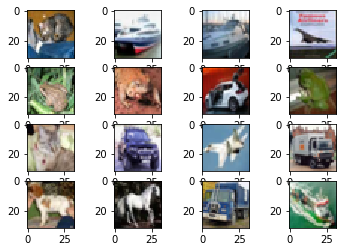

In [125]:
# Predict test images
show_imgs(x_test[:16])
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[:16]),1)
print ([labels[x] for x in indices])

In [148]:
# Predict custom image
try:
    img = cv2.imread('truck2.jfif')
    img = cv2.resize(img,(32,32))
    img = np.reshape(img,[1,32,32,3])
    img = img.astype('float32')
    img = (img-mean)/(std+1e-7)
    show_imgs(img)
except Exception as e:
    print(str(e))
index = np.argmax(model.predict(img))
print(labels[index])

OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



ValueError: If predicting from data tensors, you should specify the `steps` argument.